# Explore WRF

## Objectives

- Load WRF output file(s) and inspect variables
- Select variables for a location
- Make quick maps and plots
- Make georeferenced WRF output


In [1]:
import numpy as np
from scipy.interpolate import NearestNDInterpolator

import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import cmocean

# setting this path so we have to type less
# PATH = "/nesi/nobackup/nesi99991/ASP_winterschool2023"
PATH = "../"

In [2]:
filenames = PATH+"/WRF_exercises/outputs/control/wrfout_d01_2023-02-*_00:00:00"
ds = xr.open_mfdataset(filenames, concat_dim="Time", combine='nested', chunks={"Time": 24}, parallel=True).isel(Time=slice(1,457))
ds

<xarray.Dataset> Size: 153GB
Dimensions:                (Time: 456, south_north: 279, west_east: 229,
                            bottom_top: 59, bottom_top_stag: 60,
                            soil_layers_stag: 4, west_east_stag: 230,
                            south_north_stag: 280, seed_dim_stag: 2)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    XLONG                  (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    XTIME                  (Time) datetime64[ns] 4kB dask.array<chunksize=(23,), meta=np.ndarray>
    XLAT_U                 (Time, south_north, west_east_stag) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    XLONG_U                (Time, south_north, west_east_stag) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    XLAT_V                 (Time, south_north_stag, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    XLONG_V                (Time, south_north_stag, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/182)
    Times                  (Time) |S19 9kB dask.array<chunksize=(23,), meta=np.ndarray>
    LU_INDEX               (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    ZNU                    (Time, bottom_top) float32 108kB dask.array<chunksize=(23, 59), meta=np.ndarray>
    ZNW                    (Time, bottom_top_stag) float32 109kB dask.array<chunksize=(23, 60), meta=np.ndarray>
    ZS                     (Time, soil_layers_stag) float32 7kB dask.array<chunksize=(23, 4), meta=np.ndarray>
    DZS                    (Time, soil_layers_stag) float32 7kB dask.array<chunksize=(23, 4), meta=np.ndarray>
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    PC                     (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    LANDMASK               (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    LAKEMASK               (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    SST                    (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
    SST_INPUT              (Time, south_north, west_east) float32 117MB dask.array<chunksize=(23, 140, 115), meta=np.ndarray>
Attributes: (12/129)
    TITLE:                            OUTPUT FROM WRF V4.1.1 MODEL
    START_DATE:                      2023-02-01_00:00:00
    SIMULATION_START_DATE:           2023-02-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        230
    SOUTH-NORTH_GRID_DIMENSION:      280
    BOTTOM-TOP_GRID_DIMENSION:       60
    ...                              ...
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

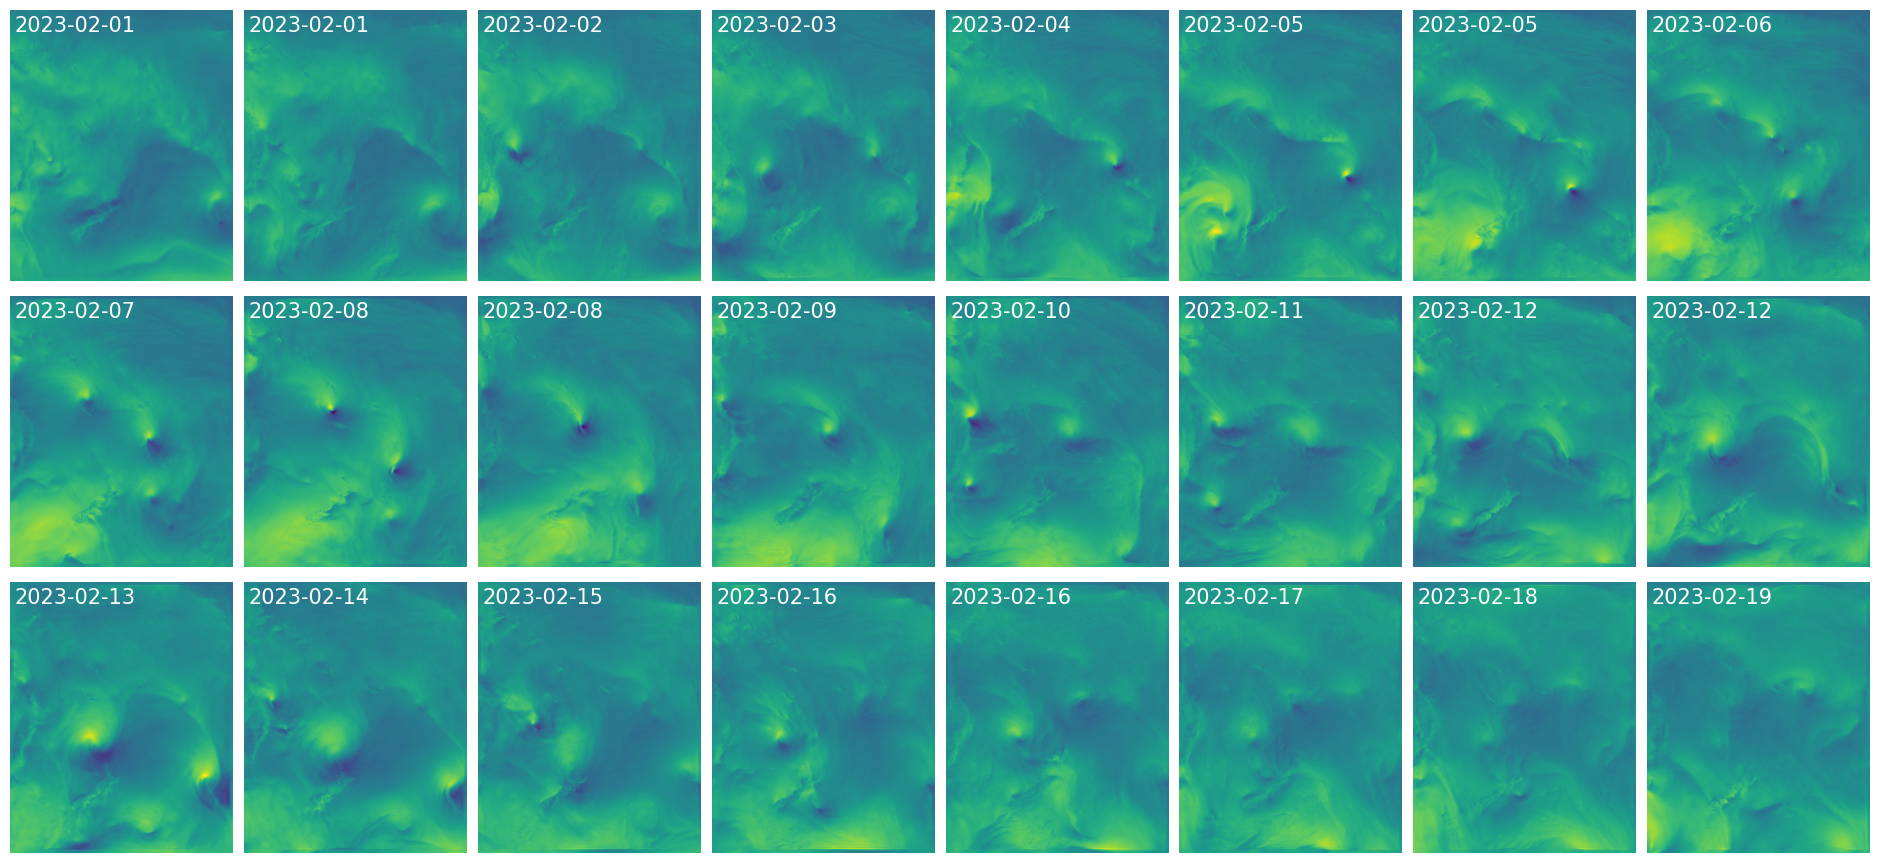

In [3]:
ncol = 8 # multiple of number of time steps -> len(ds.XTIME)
# Let's test this for consistency
try:
    assert(len(ds.XTIME) % ncol == 0)
except:
    print(f"ncol [{ncol}] is not a multiple of len(ds.XTIME) [{len(ds.XTIME)}]")
nrow = 3
res = 3
fig, ax = plt.subplots(nrow,ncol,sharex=True,sharey=True,figsize=(res*ncol,279/229*res*nrow))
ax = ax.flatten()

n_timesteps = len(ds.XTIME)

times = range(0,n_timesteps,n_timesteps//(nrow*ncol))
nt = len(times)
X = ds.U10.isel(Time=times)
TIME = ds.XTIME.isel(Time=times)
vmin = X.min().values
vmax = X.max().values

for i,t in enumerate(range(nt)):
    im = ax[i].imshow(X.isel(Time=t),vmin=vmin,vmax=vmax)
    # add time stamp for each plot
    timestamp = TIME.isel(Time=t).values.astype(str)[:10]
    ax[i].text(0.02,0.92,timestamp,color="white",size=res*5,transform=ax[i].transAxes)
    ax[i].invert_yaxis()
    ax[i].axis("off")
plt.subplots_adjust(wspace=0.05, hspace=0.05)

## Selecting a point location

- requires interpolation of coordinates using `scipy`'s [`NearestNDInterpolator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.NearestNDInterpolator.html)

In [4]:
# (nearest neighbor) interpolation for coordinates (longitude, latitude)
LON, LAT = ds.XLONG.isel(Time=0).values, ds.XLAT.isel(Time=0).values

nlat, nlon = LON.shape
print(nlon,nlat)

y = np.reshape(np.arange(nlat*nlon),(nlat,nlon))

interp = NearestNDInterpolator(list(zip(LAT.flatten(), LON.flatten())), y.flatten())

229 279


In [5]:
j, i = np.where(y==interp(-36.84,174.73))
auckland = {"south_north": j,"west_east": i}
j, i = np.where(y==interp(-38.65,178))
gisborne = {"south_north": j,"west_east": i}

# check
print(ds.XLONG.isel(auckland).isel(Time=0).values[0][0],ds.XLAT.isel(auckland).isel(Time=0).values[0][0])
print(ds.XLONG.isel(gisborne).isel(Time=0).values[0][0],ds.XLAT.isel(gisborne).isel(Time=0).values[0][0])

174.72667 -36.740784
178.11708 -38.563736


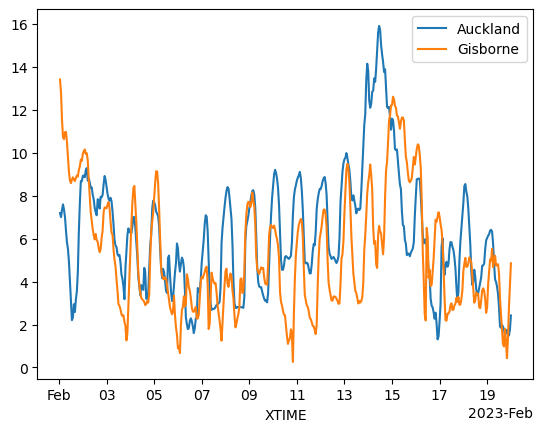

In [6]:
fig, ax = plt.subplots(1,1)

X = (ds.U10**2 + ds.V10**2)**0.5 # wind speed

X.isel(auckland).plot(ax=ax, x="XTIME", label="Auckland")
X.isel(gisborne).plot(ax=ax, x="XTIME", label="Gisborne")

ax.legend();

**Exercises**

1. Plot the timeseries again but for surface pressure (variable `PSFC`)
2. Plot the timeseries for the 2m air temperature
3. What are the up's and down's in this timeseries?

## Georeference WRF data

2023-02-13T00:00:00.000000000


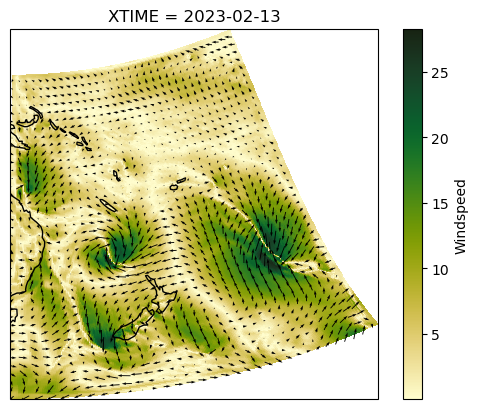

In [7]:
i = 12*24-1 # 12 days in since 2 Feb x 24h
print(ds.XTIME[i].values)

X = (ds.V10.isel(Time=i)**2 + ds.V10.isel(Time=i)**2)**0.5 
X.name = "Windspeed"

proj = ccrs.PlateCarree(central_longitude=180)

fig, ax = plt.subplots(1,1,subplot_kw={"projection": proj})
ax.coastlines()

X.plot(x="XLONG",y="XLAT", ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.speed)

step = 7
XX = ds.isel(south_north=slice(0,ds.XLONG.shape[0],step),west_east=slice(0,ds.XLONG.shape[1],step)).isel(Time=i)
XX.plot.quiver(x="XLONG",y="XLAT",u="U10",v="V10", ax=ax, transform=ccrs.PlateCarree(), add_guide=False);

**Exercises**

1. Save the plot to a PNG file
2. Plot the data in a New Zealand projection (EPSG codes 2193 or 3994)
3. Rerun the same script for your experiment (alternative scenario)